In [17]:
using Plots, Lux, Zygote, Random, Optimisers, Statistics, ComponentArrays

In [18]:
rng = MersenneTwister()
Random.seed!(rng, 1)

# Define the model
model = Chain(Dense(1 => 50, tanh), Dense(50 => 50, tanh), Dense(50 => 1)) 

# Initialize model parameters
ps, st = Lux.setup(Xoshiro(0), model)
ps = ps |> ComponentArray

# Function to evaluate the model
function trial(model, x, ps, st)
    u, st = Lux.apply(model, x, ps, st)
    return u
end

f(x) = trial(model, x, ps, st)

x = Float64.(collect(range(-1, 1, length=200)))
x = reshape(x, 1, :)
y = Float64.(cos.(x))
data = (x, y)

opt = Adam(0.01f0)

function trial(model, x, ps, st)
    u, st = Lux.apply(model, x, ps, st)
    return u
end

    #dydx = Zygote.gradient(sum ∘ smodel, x)[1]
    #print(dydx)  
    #loss = MSELoss()(d, data[2])

function loss_function(model, ps, st, data)
    x = data[1]
    f(x) = trial(model, x, ps, st)
    d = f(x)
    #dydx = TaylorDiff.derivative(f, x, Float32.(ones(size(x))), Val(1)) 
    #smodel = StatefulLuxLayer{true}(model, ps, st)
    #dydx = Zygote.gradient(sum ∘ StatefulLuxLayer{true}(tstate.model, tstate.parameters, tstate.states), x)
    #print(dydx)
    error = d .- data[2]
    loss = mean(error.^2)
    return loss, st, ()
end

ps, st = Lux.setup(rng, model)
loss_function(model, ps, st, data)

tstate = Training.TrainState(model, ps, st, opt)

grads, loss, stats, ts = Lux.Training.compute_gradients(AutoZygote(), loss_function, data, tstate)
Lux.Training.apply_gradients(ts, grads)

# Training loop
epochs = 5000
for epoch in 1:epochs
    grads, loss, stats, ts = Lux.Training.compute_gradients(AutoZygote(), loss_function, data, tstate)
    tstate = Lux.Training.apply_gradients(ts, grads)
    if epoch % 100 == 0
        println("Epoch: $epoch, Loss: $loss")
    end
end

Epoch: 100, Loss: 9.204147858042043e-5
Epoch: 200, Loss: 2.3943060304085795e-5
Epoch: 300, Loss: 1.3304601689034895e-5
Epoch: 400, Loss: 1.0063042507797043e-5
Epoch: 500, Loss: 8.013499146110677e-6
Epoch: 600, Loss: 6.537307779010935e-6
Epoch: 700, Loss: 5.4696583119694525e-6
Epoch: 800, Loss: 4.676839820667328e-6
Epoch: 900, Loss: 4.06087278459512e-6
Epoch: 1000, Loss: 3.5580494937497037e-6
Epoch: 1100, Loss: 3.130366289008626e-6
Epoch: 1200, Loss: 1.0198187454454187e-5
Epoch: 1300, Loss: 3.3279944090103957e-6
Epoch: 1400, Loss: 2.922893091903253e-6
Epoch: 1500, Loss: 2.573950271549521e-6
Epoch: 1600, Loss: 2.2654260834065858e-6
Epoch: 1700, Loss: 0.0001523006498888308
Epoch: 1800, Loss: 2.2362281541070643e-6
Epoch: 1900, Loss: 1.9082576227049654e-6
Epoch: 2000, Loss: 1.6429750539857626e-6
Epoch: 2100, Loss: 1.418644388885561e-6
Epoch: 2200, Loss: 1.2290053470614178e-6
Epoch: 2300, Loss: 5.0102712116304085e-6
Epoch: 2400, Loss: 9.757936040564426e-7
Epoch: 2500, Loss: 8.539205597863429

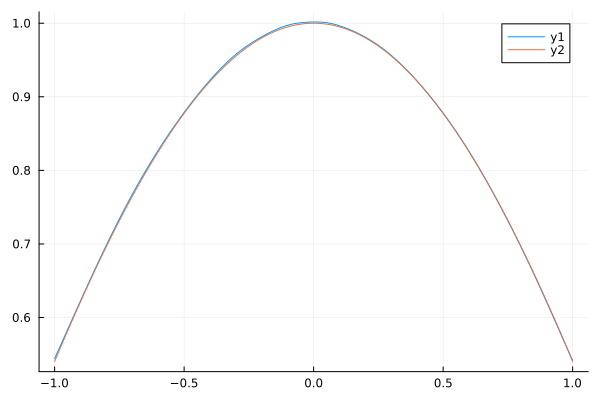

In [19]:
y_pred =  Lux.apply(tstate.model, x, tstate.parameters, tstate.states)[1] 
plot(x[1, :], y_pred[1, :])
plot!(x[1, :], y[1, :])

In [20]:
smodel = StatefulLuxLayer{true}(tstate.model, tstate.parameters, tstate.states)
only(Zygote.gradient(sum ∘ smodel, x))

1×200 Matrix{Float64}:
 0.779834  0.782079  0.783842  0.785113  …  -0.794171  -0.791143  -0.787149

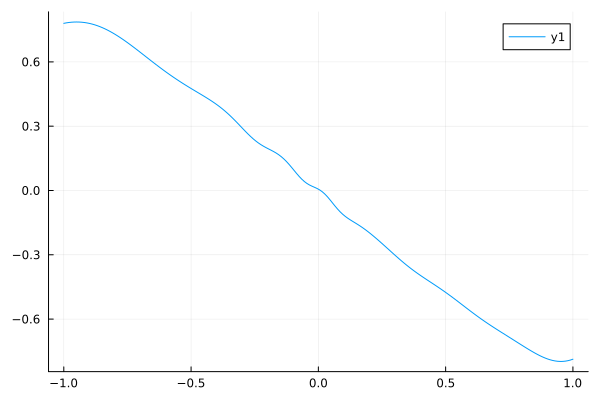

In [21]:
plot(x[1, :], only(Zygote.gradient(sum ∘ smodel, x))')

In [ ]:
plot(x[1, :], f(x)')